In [1]:
%matplotlib widget

from tqdm import trange
from matplotlib import cm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime, timezone, timedelta
import scipy.io
from matplotlib.colors import  Normalize
import math
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
A = 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                # initial displacment[mm]
SIGMA = 1 # std of initial push [mm]
MU = 4.0  # shear modulus [kPa]
ETA = 1.2 # viscosity [Pa.s] 


CS = math.sqrt(MU)  # shear wave speed [mm/ms]
RHO = 0.001 # density [kg/mm^3]

RATIO = ETA
TR_EPOCH = 1000 
N_NEUROS = 32 # number of neurons in the hidden layer
N_LAYERS = 4
# Optimisation parameters
x_range = [-20., 20.]    #[mm]
t_range = [0., 20.]      #[ms]
ic_samples = 200
xt_samples = 100000
batch_size = 50000

prediction_interval = 1000

epochs = 10000

In [3]:
# Get the current time
current_time = datetime.now(timezone(timedelta(hours=2))).strftime("%Y-%m-%d_%H-%M")

# Create the folder name with variables
folder_name = os.path.join(
    os.getcwd(),
    f"simulation{current_time}_MU_{MU}_ETA_{ETA}",
)

try:
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully!")
except FileExistsError:
    print(f"Folder '{folder_name}' already exists.")
except Exception as e:
    print(f"Error occurred while creating the folder: {e}")

Folder 'c:\Users\Wayne\Desktop\CUDI-contrast-ultrasound dispersion imaging\28_weekly_update_25052024\simulation2024-06-11_18-22_MU_4.0_ETA_1.2' created successfully!


In [4]:
sample_seed = 1024
initialization_seed = 40

In [5]:
torch.manual_seed(sample_seed)
np.random.seed(sample_seed)

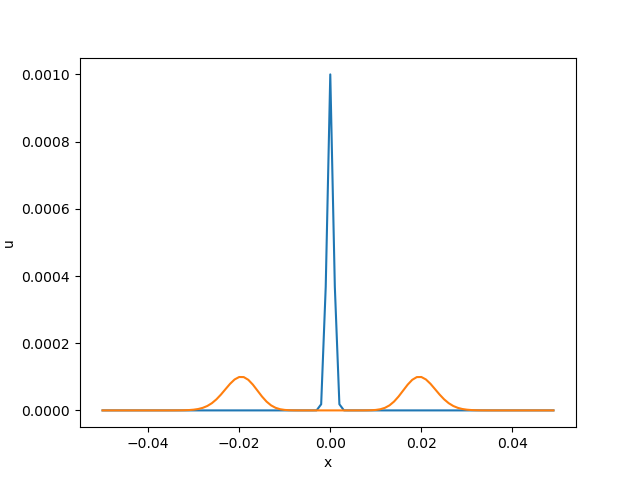

In [6]:
def get_displacement_wave_equation_output(u_init: np.array, u_init_2: np.array, DX: float, DT: float, NT: int, rho: float, mu: float, eta:float,  n_padding: int, x_values:np.array):
    NX = len(u_init) + 2 * n_padding # Add padding to deal with boundary conditions
    padding = np.zeros(n_padding)

    a = (mu * DT**2) / (rho * DX**2) #linear constant
    b = (eta * DT) / (rho * DX**2) #viscous constant


    u = np.zeros((NX, NT))
    u[:, 0] = np.hstack((padding, u_init, padding)) #add padding to deal with boundary conditions

    #As the simulation can take quite a long time to calculate and might need to be done at very small increments, it can be useful to continue a previous simulation, using the last two results from the previous simulation.
    if u_init_2 is None:
        for x in range(1, NX-1):
            u_linear = a * (u[x+1, 0] - 2 * u[x, 0] + u[x-1, 0])
            u_viscous = 0
            u[x, 1] = u_linear + u_viscous + u[x, 0]
    else:
        u[:, 1] = np.hstack((padding, u_init_2, padding))

    for t in range(1, NT-1):
        for x in range(1, NX-1):
            u_linear = a * (u[x+1, t] - 2 * u[x, t] + u[x-1, t])
            u_viscous = b *  (u[x+1, t] - 2 * u[x, t] + u[x-1, t] - u[x+1, t-1] + 2 * u[x, t-1] - u[x-1, t-1])
            u[x, t+1] = u_linear + u_viscous  + 2 * u[x, t] - u[x, t-1]

    plt.xlabel('x')
    plt.ylabel('u')

    for t in range(0, NT, 100):
        plt.plot(x_values, u[:, t])

    return u

# Function to generate a Gaussian impulse

def gaussian(x):
    return f_amp * np.exp(-x**2 / sigma**2)

# Tissue parameters
eta = ETA
mu = MU * 1e3      # Convert from mm/ms to m/s
rho = RHO * 1e6
n_padding = 0
# Simulation parameters
DX = 1e-3
DT = 1e-4
NT = 200
NX = 0.1 / DX

# Spatial values
x_values = np.arange(-0.05, 0.05, DX)

# Parameters for Gaussian impulse
f_amp = 0.001
sigma = 0.001
u_init = np.zeros(len(x_values), dtype=np.float64)

for x in range(len(u_init)):
    u_init[x] = gaussian(x_values[x])

u_fdm = get_displacement_wave_equation_output(u_init=u_init, u_init_2=None, DX=DX, DT=DT, NT=NT, rho=rho, mu=mu, eta=eta, n_padding=n_padding, x_values=x_values)

Elapsed time: 0.01751232147216797 seconds


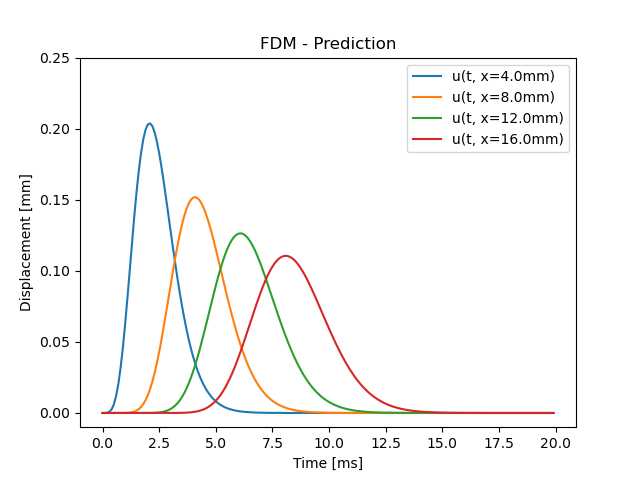

In [7]:
# Calculate time values
# Create a single figure
fdm_start_time = time.time()
fig, ax = plt.subplots()
time_values = np.arange(
    0, u_fdm.shape[1] * DT * 1000, DT * 1000
)  # Convert seconds to milliseconds

# Find the indices corresponding to the desired positions
x_positions = [0.004, 0.008, 0.012, 0.016]
x_indices = [int((x - x_values[0]) / DX) for x in x_positions]

# Select the corresponding u values for each position
u_at_positions = [u_fdm[x_index, :] for x_index in x_indices]


# Plot the selected u values against time values for each position
for i, u_at_position in enumerate(u_at_positions):
    plt.plot(
        time_values, u_at_position * 1000, label=f"u(t, x={x_positions[i]*1000}mm)"   
    )  # Convert meters to millimeters
fdm_end_time = time.time()
elapsed_time = fdm_end_time - fdm_start_time
print(f"Elapsed time: {elapsed_time} seconds")

# Add legend
plt.legend()
plt.ylim(-0.01, 0.25)
# Add labels and title
plt.xlabel("Time [ms]")  
plt.ylabel("Displacement [mm]")
plt.title("FDM - Prediction")

# Save the plot
fig.savefig(os.path.join(folder_name, "FDM - Prediction.png"))

# Show the plot
plt.show()

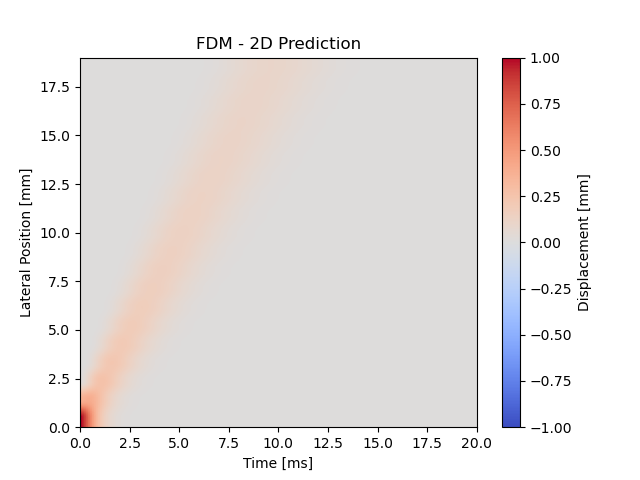

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create a new figure for the heatmap
fig, ax = plt.subplots()

# Define spatial values in millimeters
spatial_values = np.arange(0, 0.02, DX)
spatial_values_mm = spatial_values * 1000  # Convert meters to millimeters

# Create a transposed version of u
u_fdm_2d = u_fdm * 1000


# Define the desired spatial and temporal ranges in physical units
spatial_range = 0.05
spatial_start = 0  # Starting spatial position in meters
spatial_end = 0.02  # Ending spatial position in meters
temporal_end = 0.02  # Ending time in seconds

# Convert spatial and temporal ranges to indices
spatial_start_index = int((spatial_start + spatial_range) / DX)  # Convert to index
spatial_end_index = int((spatial_end + spatial_range) / DX)  # Convert to index
temporal_end_index = int(temporal_end / DT)  # Convert to index

# Define the temporal start index directly
temporal_start_index = 0  # Start index for temporal range

# Slice the u_fdm_2d array to get the desired portion of data
u_fdm_2d_sliced = u_fdm_2d[
    spatial_start_index:spatial_end_index, temporal_start_index:temporal_end_index
]
# Determine color mapping range
vmin = np.min(u_fdm_2d_sliced)
vmax = np.max(u_fdm_2d_sliced)

# Determine the absolute maximum value
abs_max = max(abs(vmin), abs(vmax))


# Plot the heatmap
heatmap = plt.imshow(
    u_fdm_2d_sliced,
    extent=[
        0,
        0.02 * 1000,
        0,
        spatial_values_mm[-1],
    ],  # Convert seconds to milliseconds
    aspect="auto",
    cmap='coolwarm',
    vmin=-abs_max,
    vmax=abs_max,
    origin="lower",
)


# Add colorbar
plt.colorbar(label="Displacement [mm]")

# Set labels and title
plt.xlabel("Time [ms]")  # Change x-axis label to milliseconds
plt.ylabel("Lateral Position [mm]")  # Change y-axis label to millimeters
plt.title("FDM - 2D Prediction")


plt.show()
fig.savefig(os.path.join(folder_name, "FDM - 2D Prediction.png"))

In [9]:
class Net(nn.Module):
    def __init__(self, n_neurons=N_NEUROS, n_layers=N_LAYERS):
        super(Net, self).__init__()
        
        # Set the random seed
        torch.manual_seed(initialization_seed)
        np.random.seed(initialization_seed)
        
        self.seq = torch.nn.Sequential()
        n_inputs = 2
        
        for i in range(n_layers):
            self.seq.add_module(f"lin_{i}", nn.Linear(n_inputs, n_neurons))
            n_inputs = n_neurons
            self.seq.add_module(f"tanh_{i}", nn.Tanh())
        
        self.seq.add_module(f"lin_{i+1}", nn.Linear(n_inputs, 1))
        
        # Set weight initialization method for each linear layer
        for module in self.seq:
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_normal_(module.weight)
        
    def forward(self, x, t):        
        return self.seq(torch.cat([x, t], axis=1))

C:\Users\Wayne\AppData\Local\Temp\ipykernel_10260\414799952.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(t_samples_cpu, x_samples_cpu, c='k', marker='.', alpha=0.2, label='Collocation points', cmap=mpl.cm.jet)
C:\Users\Wayne\AppData\Local\Temp\ipykernel_10260\414799952.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))


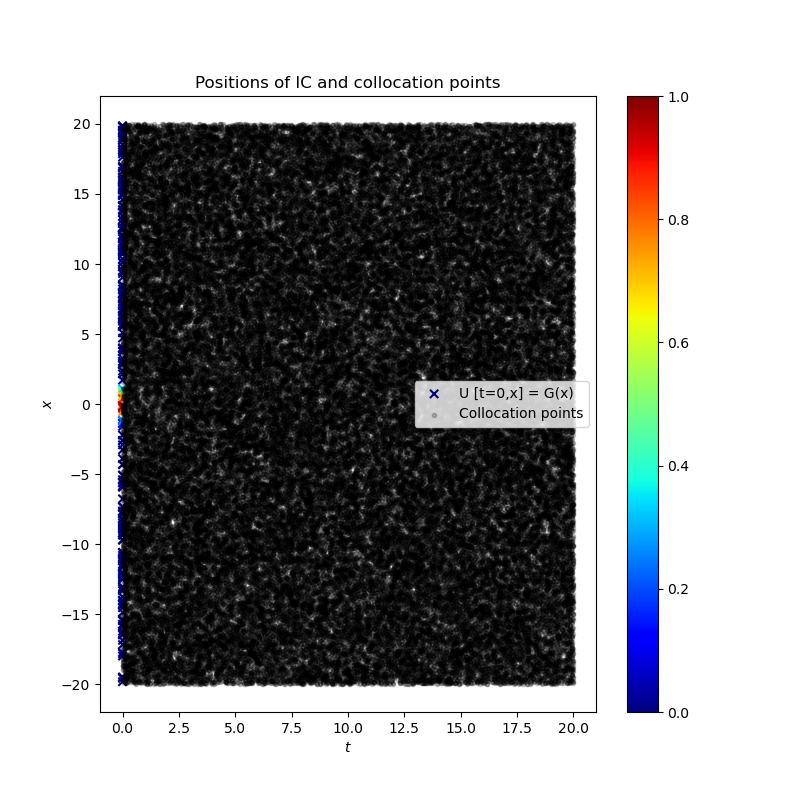

In [10]:

x_ic = torch.tensor(np.random.uniform(*x_range, (ic_samples, 1)), device=device, dtype=torch.float)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
u_ic = A * torch.exp(-1* (x_ic / SIGMA) ** 2)

epsilon = 1e-6

# x_samples = torch.tensor(np.random.uniform(*x_range, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
# t_samples = torch.tensor(np.random.uniform(*t_range, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)

x_samples = torch.tensor(np.random.uniform(x_range[0], x_range[1]-epsilon, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)
t_samples = torch.tensor(np.random.uniform(t_range[0], t_range[1]-epsilon, (xt_samples, 1)), device=device, dtype=torch.float).requires_grad_(True)


# Move tensors to CPU and convert to numpy arrays
x_ic_cpu = x_ic.cpu().detach().numpy()
t_ic_cpu = t_ic.cpu().detach().numpy()
u_ic_cpu = u_ic.cpu().detach().numpy()
x_samples_cpu = x_samples.cpu().detach().numpy()
t_samples_cpu = t_samples.cpu().detach().numpy()

# Plotting
fig = plt.figure(figsize=(8, 8))
plt.scatter(t_ic_cpu, x_ic_cpu, c=u_ic_cpu, marker='x', vmin=0, vmax=1, label='U [t=0,x] = G(x)', cmap=mpl.cm.jet)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

plt.scatter(t_samples_cpu, x_samples_cpu, c='k', marker='.', alpha=0.2, label='Collocation points', cmap=mpl.cm.jet)

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Positions of IC and collocation points')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')
fig.savefig(os.path.join(folder_name, 'collocation_points.png'))
plt.show()

In [11]:


# init conditions
x_ic = torch.tensor(np.random.uniform(*x_range, (ic_samples, 1)), device=device, dtype=torch.float)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
u_ic = A * torch.exp(-1 * (x_ic / SIGMA) ** 2)


pinn = Net(n_neurons=N_NEUROS, n_layers=N_LAYERS)
pinn = pinn.to(device)

mse_loss = torch.nn.MSELoss()
adam_optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)



roi_average_values = []
selected_x_values = [4, 8, 12, 16]
num_test_samples = 500

# Shuffle the training samples indices
indices = torch.randperm(xt_samples)

losses = [[], [], []]
for epoch in (pbar := trange(epochs)):

    # Shuffle the training samples indices at the beginning of each epoch
    indices = torch.randperm(xt_samples)

    # Iterate over batches
    for i in range(0, xt_samples, batch_size):

        # Get batch indices
        batch_indices = indices[i : i + batch_size]

        # Get batch samples
        x_batch = x_samples[batch_indices]
        t_batch = t_samples[batch_indices]

        # init conditions
        net_ic = pinn(x_ic, t_ic)
        net_dudt_ic = torch.autograd.grad(net_ic, t_ic, grad_outputs=torch.ones(net_ic.shape).to(device), create_graph=True)[0]
        loss_ic_u = mse_loss(net_ic, u_ic).to(device)
        loss_ic_dudt = mse_loss(net_dudt_ic, torch.zeros(net_ic.shape).to(device))

        # pde loss
        net_u = pinn(x_batch, t_batch).to(device)

        pred_u_x = torch.autograd.grad(
            net_u,
            x_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)

        pred_u_t = torch.autograd.grad(
            net_u,
            t_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)
        pred_u_xx = torch.autograd.grad(
            pred_u_x,
            x_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)
        pred_u_tt = torch.autograd.grad(
            pred_u_t,
            t_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)
        pred_u_xx_t = torch.autograd.grad(
            pred_u_xx,
            t_batch,
            grad_outputs=torch.ones(net_u.size()).to(device),
            create_graph=True,
        )[0].to(device)


        loss_pde = mse_loss(
            pred_u_tt - MU * pred_u_xx - ETA * pred_u_xx_t,
            torch.zeros(net_u.size()).to(device),
        )

        # Combining the loss functions
        loss = 1e0 * loss_ic_u + 1e0 * loss_ic_dudt + 1e0 * loss_pde 

        loss.backward()
        adam_optimizer.step()
        adam_optimizer.zero_grad()

        losses[0].append(loss_ic_u.item())
        losses[1].append(loss_ic_dudt.item())
        losses[2].append(loss_pde.item())

        if not epoch % 10:
            pbar.set_description(f"Loss={loss.item():.3e}")

        if epoch % prediction_interval == 0:
            # Create a single figure
            fig, ax = plt.subplots()

            # Plot u(t, x) for each selected x on the same graph
            for selected_x in selected_x_values:
                # Predict u(t, x) distribution for the fixed x
                t_flat = np.linspace(0, 20, num_test_samples)
                x_flat = np.full_like(t_flat, fill_value=selected_x)
                tx = np.stack([t_flat, x_flat], axis=-1)

                # Convert to torch tensors
                x_tensor = torch.from_numpy(tx[:, 1]).float().view(-1, 1).to(device)
                t_tensor = torch.from_numpy(tx[:, 0]).float().view(-1, 1).to(device)

                # Forward pass
                u_pinn = pinn(x_tensor, t_tensor).detach().to(device)

                # Move predicted values to CPU for plotting
                u_pinn = u_pinn.cpu().numpy()

                # Plot the result
                ax.plot(t_flat, u_pinn, label=f"u(t, x={selected_x}mm)")

            ax.set_title(f"Prediction_epoch_{epoch}")
            ax.set_xlabel("Time [ms]")
            ax.set_ylabel("Displacement [mm]")
            ax.legend()

            # Save the image with a unique name
            image_name = f"Prediction_epoch_{epoch}.png"
            fig.savefig(os.path.join(folder_name, image_name))
            plt.close(fig)

            # Define the ranges for time (t) and spatial position (x)
            t_2d_test_range = np.linspace(0, 20, num_test_samples)
            x_2d_test_range = np.linspace(0, 20, num_test_samples)

            # Create 2D meshgrid for time (t) and spatial position (x)
            mg_2d_t, mg_2d_x = np.meshgrid(t_2d_test_range, x_2d_test_range)

            # Convert meshgrid to torch tensors
            t_tensor_2d = torch.from_numpy(mg_2d_t).float().view(-1, 1).to(device)
            x_tensor_2d = torch.from_numpy(mg_2d_x).float().view(-1, 1).to(device)

            fig, ax = plt.subplots()

            # Forward pass to obtain u values for PINN - 2D Prediction
            u_pinn = pinn(x_tensor_2d, t_tensor_2d).detach().cpu().numpy()

            # Reshape u to match the shape of the meshgrid
            u_pinn_2d = u_pinn.reshape(mg_2d_t.shape)

            # Select a small region in the bottom right corner of the image and compute the average
            bottom_right_corner = u_pinn_2d[
                -10:, -10:
            ]  # Select a 10x10 region in the bottom right corner
            region_average = np.nanmean(bottom_right_corner)  # Compute the average

            # Append the average value to the list
            roi_average_values.append(region_average)

            # Plot the heatmap for lateral position (x) greater than 0
            im = ax.imshow(
                np.where(mg_2d_x >= 0, u_pinn_2d, np.nan),
                extent=[
                    np.min(t_2d_test_range),
                    np.max(t_2d_test_range),
                    np.min(x_2d_test_range),
                    np.max(x_2d_test_range),
                ],
                cmap="coolwarm",
                aspect="auto",
                origin="lower",
                norm=Normalize(
                    vmin=-np.max(np.abs(u_pinn)), vmax=np.max(np.abs(u_pinn))
                ),
            )

            # Set labels and title
            ax.set_xlabel("Time [ms]")
            ax.set_ylabel("Lateral Position [mm]")
            ax.set_title("PINN - 2D Prediction")

            # Add a colorbar
            cbar = fig.colorbar(im, ax=ax)
            cbar.set_label("Displacement [mm]")

            plt.ylim(0, 20)  # Limit y-axis to the range from 0 to 20

            fig.savefig(
                os.path.join(folder_name, f"PINN - 2D Prediction_epoch_{epoch}.png")
            )
            plt.close(fig)

Loss=1.532e-06: 100%|██████████| 10000/10000 [16:53<00:00,  9.86it/s]


In [12]:
torch.save(pinn.state_dict(), os.path.join(folder_name, "model.pth"))

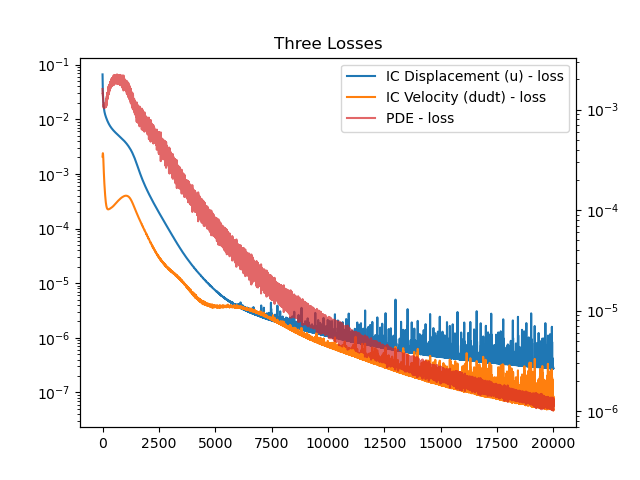

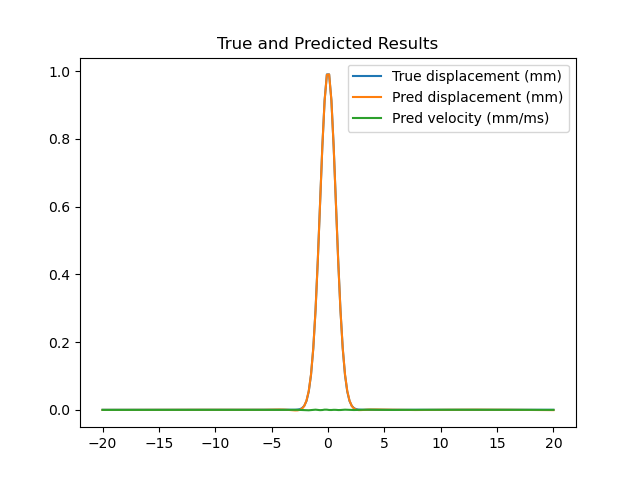

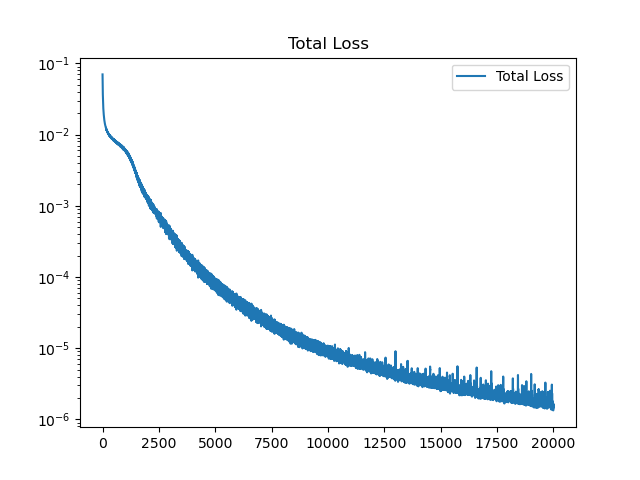

In [13]:

x_ic = (
    torch.linspace(*x_range, ic_samples, device=device, dtype=torch.float)
    .view(-1, 1)
    .requires_grad_(True)
)
t_ic = torch.zeros_like(x_ic, device=device).requires_grad_(True)
net_ic_u = pinn(x_ic, t_ic)
net_dudt_ic = torch.autograd.grad(
    net_ic_u, t_ic, grad_outputs=torch.ones_like(net_ic_u), create_graph=True
)[0]
true_ic_u = A * torch.exp(-1 * (torch.linspace(*x_range, ic_samples) / SIGMA) ** 2)

# Plot 1: True and Predicted Results
fig1, ax1 = plt.subplots()
ax1.plot(
    np.linspace(*x_range, ic_samples),
    true_ic_u.cpu().detach(),
    label="True displacement (mm)"
)
ax1.plot(
    np.linspace(*x_range, ic_samples),
    net_ic_u.cpu().detach(),
    label="Pred displacement (mm)"
)
ax1.plot(
    np.linspace(*x_range, ic_samples),
    net_dudt_ic.cpu().detach(),
    label="Pred velocity (mm/ms)"
)
ax1.legend()
ax1.set_title("True and Predicted Results")
fig1.savefig(os.path.join(folder_name, "True_and_Predicted_Results.png"))
# plt.close(fig1)



# Plot 2: Total Loss
total_loss = [
    losses[0][i] + losses[1][i] + losses[2][i]
    for i in range(min(len(losses[0]), len(losses[1]), len(losses[2])))
]
fig2, ax2 = plt.subplots()
ax2.plot(total_loss, label="Total Loss")
ax2.set_yscale("log")
ax2.legend()
ax2.set_title("Total Loss")
fig2.savefig(os.path.join(folder_name, "Total_Loss.png"))
# plt.close(fig2)

# Plot 3: Three Losses
fig3, ax3 = plt.subplots()
twinx_1 = ax3.twinx()
ln1 = ax3.plot(losses[0], label="IC Displacement (u) - loss")
ln2 = ax3.plot(losses[1], label="IC Velocity (dudt) - loss")
ax3.set_yscale("log")
ln4 = twinx_1.plot(losses[2], c="C3", alpha=0.7, label="PDE - loss")
twinx_1.set_yscale("log")

lns = ln1 + ln2 + ln4
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)
ax3.set_title("Three Losses")
fig3.savefig(os.path.join(folder_name, "Three_Losses.png"))
# plt.close(fig3)

plt.show()

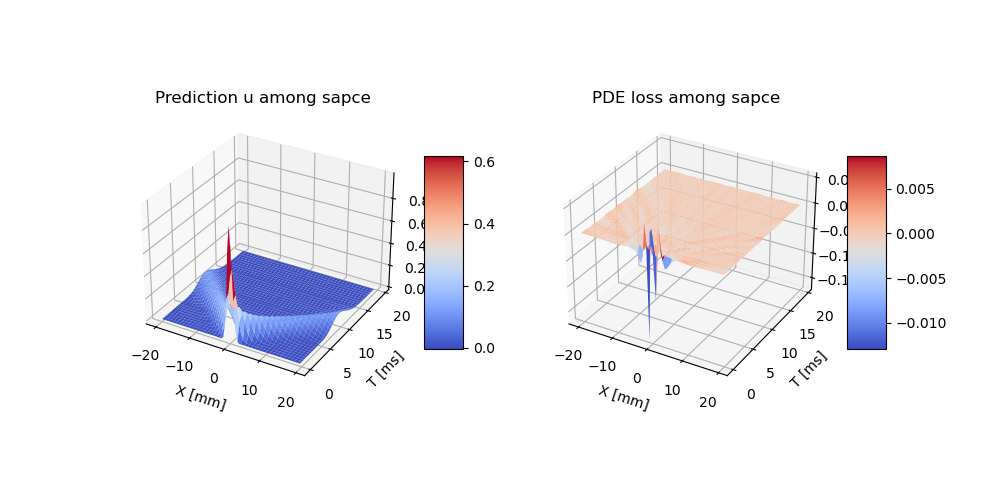

In [14]:
from matplotlib import cm

fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

x_test_range = [-20.0, 20.0]  # [mm]
t_test_range = [0.0, 20.0]  # [ms]


x = np.arange(*x_range, 0.5)
t = np.arange(*t_range, 0.5)
mg_x, mg_t = np.meshgrid(x, t, indexing='ij')

x_test = torch.from_numpy(mg_x.reshape((-1, 1))).float().to(device).requires_grad_(True)
t_test = torch.from_numpy(mg_t.reshape((-1, 1))).float().to(device).requires_grad_(True)

net_u = pinn(x_test, t_test)

pred_u_x = torch.autograd.grad(
    net_u, x_test, grad_outputs=torch.ones(net_u.size()).to(device), create_graph=True
)[0]
pred_u_t = torch.autograd.grad(
    net_u, t_test, grad_outputs=torch.ones(net_u.size()).to(device), create_graph=True
)[0]
pred_u_xx = torch.autograd.grad(
    pred_u_x,
    x_test,
    grad_outputs=torch.ones(net_u.size()).to(device),
    create_graph=True,
)[0]
pred_u_tt = torch.autograd.grad(
    pred_u_t,
    t_test,
    grad_outputs=torch.ones(net_u.size()).to(device),
    create_graph=True,
)[0]
pred_u_xx_t = torch.autograd.grad(
    pred_u_xx,
    t_test,
    grad_outputs=torch.ones(net_u.size()).to(device),
    create_graph=True,
)[0]

pde_loss = pred_u_tt - MU * pred_u_xx - ETA * pred_u_xx_t


net_u = net_u.detach().cpu().numpy().reshape(mg_x.shape)
pde_loss = pde_loss.detach().cpu().numpy().reshape(mg_x.shape)

surf = axes[0].plot_surface(mg_x, mg_t, net_u, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)

surf = axes[1].plot_surface(mg_x, mg_t, pde_loss, cmap=cm.coolwarm, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)

axes[0].set(xlabel='X [mm]', ylabel='T [ms]')
axes[0].set_title('Prediction u among sapce ')

axes[1].set(xlabel='X [mm]', ylabel='T [ms]')
axes[1].set_title('PDE loss among sapce ')
plt.show()
fig.savefig(os.path.join(folder_name, 'Loss among space.png'))

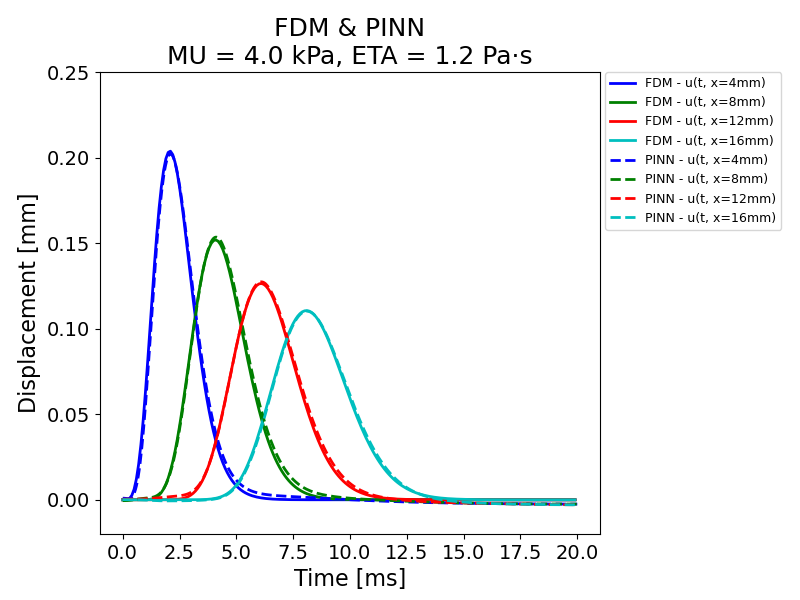

In [15]:

# Define colors for each position
colors = ["b", "g", "r", "c"]  # Blue, Green, Red, Cyan

# Calculate time values for FDM
fig, ax = plt.subplots(figsize=(8, 6)) 

time_values = np.arange(0, u_fdm.shape[1] * DT * 1000, DT * 1000)  # Convert seconds to milliseconds

# Find the indices corresponding to the desired positions
x_positions = [0.004, 0.008, 0.012, 0.016]  # Positions in meters for FDM
x_indices_fdm = [int((x - x_values[0]) / DX) for x in x_positions]  # Indices for FDM

# Convert x_positions from meters to millimeters for PINN
x_positions_pinn = [x * 1000 for x in x_positions]

# Select the corresponding u values for each position in FDM
u_at_positions_fdm = [u_fdm[x_index, :] for x_index in x_indices_fdm]

# Plot the selected u values against time values for each position in FDM using solid lines
for i, (u_at_position_fdm, color) in enumerate(zip(u_at_positions_fdm, colors)):
    plt.plot(
        time_values,
        u_at_position_fdm * 1000,
        label=f"FDM - u(t, x={int(x_positions[i]*1000)}mm)",
        linestyle="-",
        color=color,
        linewidth=2  # Increase line width for better visibility
    )

# Plot PINN results
selected_x_values = [4, 8, 12, 16]  # Positions in millimeters for PINN
num_test_samples = 500

# Set the model to evaluation mode
pinn.eval()

# Plot u(t, x) for each selected x on the same graph using dashed lines
for i, selected_x in enumerate(selected_x_values):
    # Predict u(t, x) distribution for the fixed x
    t_flat = np.linspace(0, 20, num_test_samples)
    x_flat = np.full_like(t_flat, fill_value=selected_x)
    tx = np.stack([t_flat, x_flat], axis=-1)

    # Convert to torch tensors
    x_tensor = torch.from_numpy(tx[:, 1]).float().view(-1, 1).to(device)
    t_tensor = torch.from_numpy(tx[:, 0]).float().view(-1, 1).to(device)

    # Forward pass
    u_pinn = pinn(x_tensor, t_tensor).detach()

    # Move predicted values to CPU for plotting
    u_pinn = u_pinn.cpu().numpy()

    # Plot the result
    ax.plot(
        t_flat,
        u_pinn,
        label=f"PINN - u(t, x={selected_x}mm)",
        linestyle="--",
        color=colors[i],
        linewidth=2  # Increase line width for better visibility
    )

# Add legend
plt.legend(fontsize=9, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

# Add labels and title
plt.xlabel("Time [ms]", fontsize=16)
plt.ylabel("Displacement [mm]", fontsize=16)
plt.title(f"FDM & PINN\nMU = {MU} kPa, ETA = {ETA} Pa·s", fontsize=18)

# Increase tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(-0.02, 0.25)
# Adjust layout to make space for the legend without changing the plot size
fig.subplots_adjust(right=0.75)
# Save the plot
fig.savefig(os.path.join(folder_name, "FDM & PINN MU = {MU} kPa, ETA = {ETA} Pa·s.png"))

# Show the plot
plt.show()


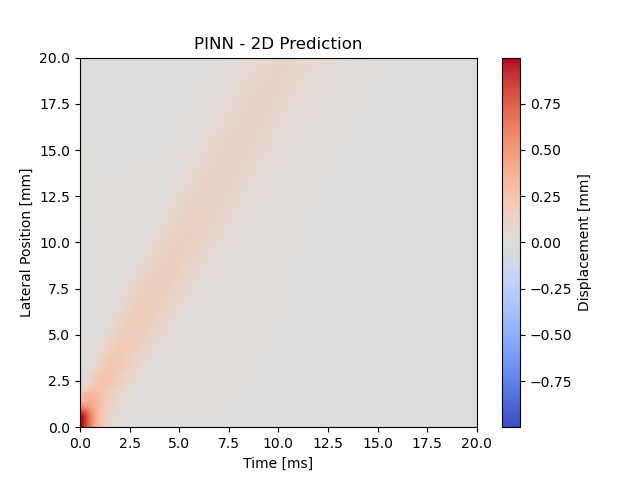

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

# Define the ranges for time (t) and spatial position (x)
t_test_range = np.linspace(0, 20, NT)
x_test_range = np.linspace(0, 20, int(NX*0.2))

# Create 2D meshgrid for time (t) and spatial position (x)
mg_t, mg_x = np.meshgrid(t_test_range, x_test_range)

# Convert meshgrid to torch tensors
t_tensor = torch.from_numpy(mg_t).float().view(-1, 1).to(device)
x_tensor = torch.from_numpy(mg_x).float().view(-1, 1).to(device)

# Forward pass to obtain u values
u_pinn = pinn(x_tensor, t_tensor).detach().cpu().numpy()

# Reshape u to match the shape of the meshgrid
u_pinn_2d = u_pinn.reshape(mg_t.shape)

# Create custom colormap
colors = [(0, "blue"), (0.5, "white"), (1, "red")]  # Blue to White to Red colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Create a new figure for the heatmap
fig, ax = plt.subplots()

# Plot the heatmap for lateral position (x) greater than 0
im = ax.imshow(
    np.where(
        mg_x >= 0, u_pinn_2d, np.nan
    ),  # Only plot where lateral position (x) is greater than 0
    extent=[
        np.min(t_test_range),
        np.max(t_test_range),
        np.min(x_test_range),
        np.max(x_test_range),
    ],
    cmap="coolwarm",
    aspect="auto",
    origin="lower",
    norm=Normalize(vmin=-np.max(np.abs(u_pinn)), vmax=np.max(np.abs(u_pinn))),
)

# Set labels and title
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Lateral Position [mm]")
ax.set_title("PINN - 2D Prediction")

# Add a colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Displacement [mm]")

plt.ylim(0, 20)  # Limit y-axis to the range from 0 to 20

plt.show()
fig.savefig(os.path.join(folder_name, "PINN - 2D Prediction.png"))

In [17]:
print("Shape of u_pinn_2d:", u_pinn_2d.shape)
print("Shape of u_fdm_2d:", u_fdm_2d_sliced.shape)

Shape of u_pinn_2d: (20, 200)
Shape of u_fdm_2d: (20, 200)


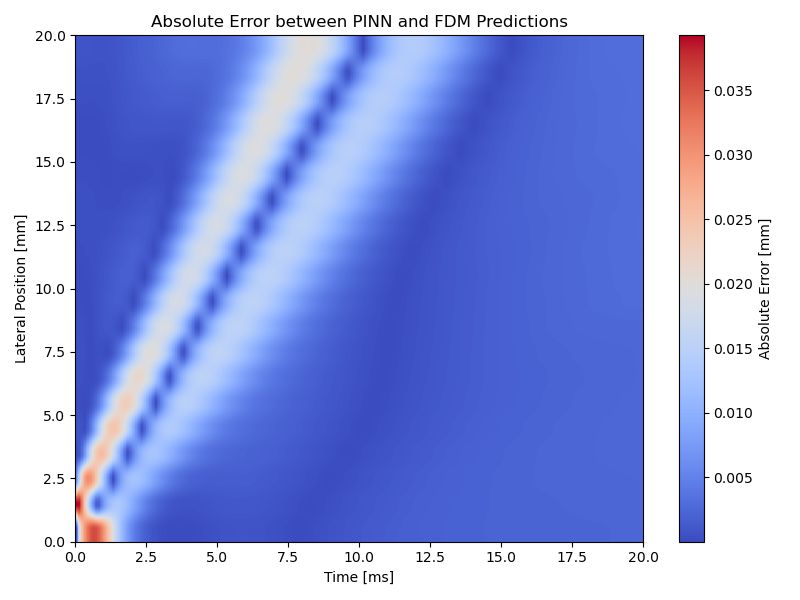

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute error between cropped heatmaps
absolute_error_cropped = np.abs(u_pinn_2d - u_fdm_2d_sliced)

# Create a new figure for the cropped absolute error heatmap
plt.figure(figsize=(8, 6))

# Plot the cropped absolute error heatmap
plt.imshow(
    absolute_error_cropped,
    cmap="coolwarm",
    aspect="auto",
    origin="lower",
    extent=[
        np.min(x_test_range),
        np.max(x_test_range),
        np.min(t_test_range),
        np.max(t_test_range),
    ],
)

# Set labels and title
plt.xlabel("Time [ms]")
plt.ylabel("Lateral Position [mm]")
plt.title("Absolute Error between PINN and FDM Predictions")
plt.colorbar(label="Absolute Error [mm]")

plt.tight_layout()
plt.savefig(os.path.join(folder_name, "Error map.png"))
plt.show()

In [22]:

# Compute absolute error between cropped heatmaps
absolute_error_cropped = np.abs(u_pinn_2d - u_fdm_2d_sliced)

# Compute MSE
mse = np.mean(absolute_error_cropped ** 2)

# Compute RMSE
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE) of the cropped absolute error heatmap:", mse)
print("Root Mean Squared Error (RMSE) of the cropped absolute error heatmap:", rmse)


Mean Squared Error (MSE) of the cropped absolute error heatmap: 5.1479310975281705e-05
Root Mean Squared Error (RMSE) of the cropped absolute error heatmap: 0.007174908429748892


: 

In [21]:

# Create a string with variable values and MSE
variables_content = (
    f"A = {A}\n"
    f"SIGMA = {SIGMA}\n"
    f"MU = {MU}\n"
    f"ETA = {ETA}\n"
    f"CS = {CS}\n"
    f"RHO = {RHO}\n"
    f"RATIO = {RATIO}\n"
    f"TR_EPOCH = {TR_EPOCH}\n"
    f"N_NEUROS = {N_NEUROS}\n"
    f"N_LAYERS = {N_LAYERS}\n"
    f"x_range = {x_range}\n"
    f"t_range = {t_range}\n"
    f"ic_samples = {ic_samples}\n"
    f"xt_samples = {xt_samples}\n"
    f"batch_size = {batch_size}\n"
    f"prediction_interval = {prediction_interval}\n"
    f"epochs = {epochs}\n"
    f"\nMean Squared Error (MSE) of the cropped absolute error heatmap: {mse}"
)

# Save the string to a text file
txt_file_path = os.path.join(folder_name, 'variables_and_mse.txt')
with open(txt_file_path, 'w') as txt_file:
    txt_file.write(variables_content)

print(f"Variables and MSE saved to '{txt_file_path}'.")


Variables and MSE saved to 'c:\Users\Wayne\Desktop\CUDI-contrast-ultrasound dispersion imaging\28_weekly_update_25052024\simulation2024-06-11_18-22_MU_4.0_ETA_1.2\variables_and_mse.txt'.
